In [152]:
#####Non Negative Tensor Factorization#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [153]:
####データの発生####
##データの設定
type_n = 3   
k = 10   #基底数
hh = 10000   #ユーザー数
item = 3000   #アイテム数
context = 30   #コンテキスト数
pt = np.random.poisson(np.random.gamma(27.5, 1/0.2, hh), hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)   #総レコード数
vec_k = np.repeat(1, k)

In [154]:
##IDとインデックスを設定
#IDを設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
user_vec = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
    user_vec[i] = np.repeat(1, pt[i])

In [155]:
##アイテムの割当を生成
#セグメント割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(2.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
    
#インデックスの設定
item_list = [j for j in range(item)]
item_vec = [j for j in range(item)]
item_n = np.repeat(0, item)
for j in range(item):
    item_list[j] = index[item_id==j]
    item_vec[j] = np.repeat(1, len(item_list[j]))
    item_n[j] = len(item_list[j])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [156]:
##コンテキストの割当
#セグメント割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, context), topic)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からコンテキストを生成
context_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    context_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(context))
    
#インデックスの設定
context_list = [j for j in range(context)]
context_vec = [j for j in range(context)]
context_n = np.repeat(0, context)
for j in range(context):
    context_list[j] = index[context_id==j]
    context_vec[j] = np.repeat(1, len(context_list[j]))
    context_n[j] = len(context_list[j])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [157]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k1 = 3; k2 = 5; k3 = 5
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
col_u = u.shape[1]

#アイテムの説明変数を生成
k1 = 4; k2 = 5; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
col_v = v.shape[1]

In [158]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    
    ##パラメータを生成
    #階層モデルの回帰係数行列を生成
    alpha_u1 = np.vstack((np.random.uniform(-1.0, 0.5, k), np.random.normal(0, 0.5, k*(col_u-1)).reshape(col_u-1, k)))
    alpha_v1 = np.vstack((np.random.uniform(-1.0, 0.5, k), np.random.normal(0, 0.5, k*(col_v-1)).reshape(col_v-1, k)))
    alpha_c1 = np.array([0.25, 0.5])
    alpha_u2 = np.vstack((np.random.uniform(-1.0, 0.5, k), np.random.normal(0, 0.4, k*(col_u-1)).reshape(col_u-1, k)))
    alpha_v2 = np.vstack((np.random.uniform(-1.0, 0.5, k), np.random.normal(0, 0.4, k*(col_v-1)).reshape(col_v-1, k)))
    alpha_c2 = np.array([0.25, 0.5])
    alpha_ut1 = alpha_u1.copy(); alpha_vt1 = alpha_v1.copy()
    alpha_ut2 = alpha_u2.copy(); alpha_vt2 = alpha_v2.copy()
    
    #ガンマ分布の尺度パラメータを生成
    lambda_u1 = np.exp(np.dot(u, alpha_u1))
    lambda_v1 = np.exp(np.dot(v, alpha_v1))
    lambda_u2 = np.exp(np.dot(u, alpha_u2))
    lambda_v2 = np.exp(np.dot(v, alpha_v2))

    #ガンマ分布の形状パラメータを生成
    beta_u1 = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.5)
    beta_v1 = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.5)
    beta_c1 = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.5)
    beta_u2 = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.25)
    beta_v2 = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.25)
    beta_c2 = scipy.stats.truncnorm.rvs(0.75, 3.0, loc=0, scale=1.25)
    beta_ut1 = beta_u1; beta_vt1 = beta_v1; beta_ct1 = beta_c1
    beta_ut2 = beta_u1; beta_vt2 = beta_v2; beta_ct2 = beta_c2

    #ガンマ分布から行列分解のパラメータを生成
    theta_u1 = np.random.gamma(lambda_u1, 1/beta_u2)
    theta_v1 = np.random.gamma(lambda_v1, 1/beta_v2)
    theta_c1 = np.random.gamma(alpha_c1[0], 1/alpha_c1[1], context*k).reshape(context, k)
    theta_u2 = np.random.gamma(lambda_u2, 1/beta_u2)
    theta_v2 = np.random.gamma(lambda_v2, 1/beta_v2)
    theta_c2 = np.random.gamma(alpha_c2[0], 1/alpha_c2[1], context*k).reshape(context, k)
    theta_ut1 = theta_u1.copy(); theta_vt1 = theta_v1.copy(); theta_ct1 = theta_c1.copy()
    theta_ut2 = theta_u2.copy(); theta_vt2 = theta_v2.copy(); theta_ct2 = theta_c2.copy()

    ##ポアソン分布から応答変数を生成
    #NMFの期待値を設定
    uv = np.dot(theta_u1[user_id, ] * theta_v1[item_id, ], vec_k)
    uc = np.dot(theta_u1[user_id, ] * theta_c1[context_id, ], vec_k)
    vc = np.dot(theta_v1[item_id, ] * theta_c1[context_id, ] , vec_k)
    uvc = np.dot(theta_u2[user_id, ] * theta_v2[item_id, ] * theta_c2[context_id, ], vec_k)
    WH = uv + uc + vc + uvc

    #期待値から応答変数を生成
    y = np.random.poisson(WH, hhpt)
    y_vec = y.reshape(hhpt, 1)

    #break条件
    print(np.array([rp, np.max(y), np.sum(y==0)]))
    if (np.max(y) < 200) & (np.max(y) > 75) & (np.sum(y==0) > 25000) & (np.sum(y==0) < 150000):
        break

[    1   408 12203]
[   2  541 2546]
[   3  364 1859]
[    4   146 12885]
[   5  259 9845]
[   6  270 2774]
[   7 2076  291]
[    8   405 12168]
[    9   253 15440]
[  10  420 2304]
[ 11 552 128]
[  12  385 2185]
[ 13 629 532]
[ 14 428 881]
[  15  215 2511]
[  16 1583  835]
[  17  218 2294]
[  18  227 7269]
[   19   202 18355]
[ 20 639 518]
[ 21 533 957]
[  22  239 8201]
[  23  601 1437]
[  24  512 8626]
[ 25 593 137]
[   26   201 10246]
[  27  260 3066]
[ 28 396 247]
[ 29 484 937]
[  30 1621 1004]
[  31  246 2013]
[  32  802 4982]
[  33  244 8685]
[  34  193 5289]
[  35  485 4371]
[  36  334 7930]
[  37  703 8940]
[  38  177 4707]
[  39  431 2018]
[   40   287 10570]
[ 41 567 878]
[  42  185 5986]
[ 43 700 766]
[   44   115 15249]
[ 45 522 613]
[  46  735 1959]
[ 47 741 746]
[  48  501 1692]
[  49  421 1392]
[   50   166 17155]
[  51  372 2852]
[ 52 869 137]
[   53   302 10320]
[  54  286 2421]
[  55  607 3064]
[  56  180 4258]
[  57  319 5970]
[   58   177 12686]
[   59    96 33180]


10242729
7.463533157967603


(array([9.96799e+05, 3.20675e+05, 4.48820e+04, 8.26400e+03, 1.32800e+03,
        3.06000e+02, 8.50000e+01, 1.90000e+01, 7.00000e+00, 5.00000e+00]),
 array([ 0. ,  9.6, 19.2, 28.8, 38.4, 48. , 57.6, 67.2, 76.8, 86.4, 96. ]),
 <a list of 10 Patch objects>)

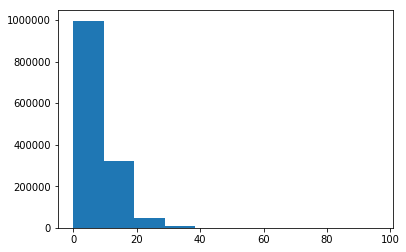

In [159]:
#生成した応答変数を確認
print(np.sum(y))
print(np.mean(y))
plt.hist(y)

In [160]:
####テストデータを作成####
##テストデータのIDを作成
#欠損インデックスを設定
z = np.random.binomial(1, 0.005, hh*item*context)
index_z = np.array(np.where(z==1)[0], dtype="int")
del z

#IDを作成
user_id0 = np.repeat(range(hh), item*context)[index_z]
item_id0 = np.tile(range(item), hh*context)[index_z]
context_id0 = np.tile(range(context), hh*item)[index_z]
N = user_id0.shape[0]

In [161]:
##応答変数を生成
#NMFの期待値を設定
uv = np.dot(theta_u1[user_id0, ] * theta_v1[item_id0, ], vec_k)
uc = np.dot(theta_u1[user_id0, ] * theta_c1[context_id0, ], vec_k)
vc = np.dot(theta_v1[item_id0, ] * theta_c1[context_id0, ] , vec_k)
uvc = np.dot(theta_u2[user_id0, ] * theta_v2[item_id0, ] * theta_c2[context_id0, ], vec_k)
WH = uv + uc + vc + uvc

#期待値から応答変数を生成
y0 = np.random.poisson(WH, N)
y_vec0 = y0.reshape(N, 1)

In [162]:
####マルコフ連鎖モンテカルロ法でNon Negative Tensor Factorizationを推定####
##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha_vec, beta, tau_inv, d, d_log, x, type_n):

    #期待値を設定
    alpha = alpha_vec.reshape(col_u, 2, order="F")
    mu = np.dot(x, alpha)
    Lambda = np.exp(mu)

    #ガンマ回帰モデルの対数尤度
    Lho = 0
    for j in range(type_n):
        lbeta = math.lgamma(beta[j])
        Lho += np.sum(beta[j] * (-d[:, j]/Lambda[:, j] - mu[:, j]) + beta[j]*np.log(beta[j]) - lbeta + (beta[j]-1)*d_log[:, j])

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(alpha_vec, tau_inv), alpha_vec)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

#ガンマ回帰の対数事後分布の微分関数
def dloglike_alpha(alpha_vec, beta, tau_inv, d, d_log, x, type_n, n, col):

    #期待値を設定
    alpha = alpha_vec.reshape(col, type_n, order="F")
    mu = np.dot(x, alpha)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.array([])
    for j in range(type_n):
        Lambda_sq = np.power(Lambda[:, j], 2)
        dlgamma = np.append(dlgamma, np.sum(((d[:, j]-Lambda[:, j]) / (Lambda_sq/beta[j]) * Lambda[:, j]).reshape(n, 1) * x, axis=0))
    dmvn = np.dot(-tau_inv1, alpha_vec)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, tau_inv, d, d_log, x, n, type_n, col): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, tau_inv, d, d_log, x, type_n, n, col) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, tau_inv, d, d_log, x, type_n, n, col) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [163]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k, type_n):
    
    #パラメータの設定
    beta_u = beta[index_beta1]
    beta_v = beta[index_beta2]

    #期待値の設定
    mu_u = np.append(np.dot(u, alpha_u[0]).reshape(-1), np.dot(u, alpha_u[1]).reshape(-1)).reshape(hh*k, 2, order="F")
    mu_v = np.append(np.dot(v, alpha_v[0]).reshape(-1), np.dot(v, alpha_v[1]).reshape(-1)).reshape(item*k, 2, order="F")
    lambda_u = np.exp(mu_u)
    lambda_v = np.exp(mu_v)

    #ガンマ回帰モデルの対数尤度
    Lho1 = 0; Lho2 = 0
    for j in range(type_n):
        lbeta_u = math.lgamma(beta_u[j]); lbeta_v = math.lgamma(beta_v[j])
        logbeta_u = np.log(beta_u[j]); logbeta_v = np.log(beta_v[j])
        Lho1 += np.sum(beta_u[j] * (-d1[:, j]/lambda_u[:, j] - mu_u[:, j]) + beta_u[j]*logbeta_u - lbeta_u + (beta_u[j]-1)*d_log1[:, j])
        Lho2 += np.sum(beta_v[j] * (-d2[:, j]/lambda_v[:, j] - mu_v[:, j]) + beta_v[j]*logbeta_v - lbeta_v + (beta_v[j]-1)*d_log2[:, j])

    #対数事後分布の和
    LL = Lho1 + Lho2
    return LL 

#形状パラメータの微分関数
def dloglike_beta(beta, alpha_u, alpha_v, d1, d2, u, v, hh, item, k, index_beta1, index_beta2):
    
    #パラメータを設定
    beta_u = beta[index_beta1]
    beta_v = beta[index_beta2]

    #期待値の設定
    mu_u = np.append(np.dot(u, alpha_u[0]).reshape(-1), np.dot(u, alpha_u[1]).reshape(-1)).reshape(hh*k, 2, order="F")
    mu_v = np.append(np.dot(v, alpha_v[0]).reshape(-1), np.dot(v, alpha_v[1]).reshape(-1)).reshape(item*k, 2, order="F")
    lambda_u = np.exp(mu_u)
    lambda_v = np.exp(mu_v)

    #微分関数の和
    dlgamma_u = np.repeat(0.0, type_n-1); dlgamma_v = np.repeat(0.0, type_n-1)
    for j in range(type_n-1):
        dbeta_u = scipy.special.digamma(beta_u[j]); dbeta_v = scipy.special.digamma(beta_v[j])
        logbeta_u = np.log(beta_u[j]); logbeta_v = np.log(beta_v[j])
        dlgamma_u[j] = (hh*k)*(logbeta_u - dbeta_u) + np.sum(1 - d1[:, j]/lambda_u[:, j] + np.log(d1[:, j]/lambda_u[:, j]))
        dlgamma_v[j] = (item*k)*(logbeta_v - dbeta_v) + np.sum(1 - d2[:, j]/lambda_v[:, j] + np.log(d2[:, j]/lambda_v[:, j]))
    dlgamma = -np.append(dlgamma_u, dlgamma_v)
    return dlgamma

#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k, index_beta1, index_beta2): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha_u, alpha_v, d1, d2, u, v, hh, item, k, index_beta1, index_beta2) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha_u, alpha_v, d1, d2, u, v, hh, item, k, index_beta1, index_beta2) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [164]:
##アルゴリズムの設定
R = 2000
keep = 4
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.0025
e2 = 0.001
L = 3

In [165]:
##データの設定
#パラメータのインデックス
index_alpha11 = np.array(range(col_u))
index_alpha21 = np.delete(np.arange((type_n-1)*col_u), index_alpha11)
index_alpha12 = np.array(range(col_v))
index_alpha22 = np.delete(np.arange((type_n-1)*col_v), index_alpha12)
index_beta1 = np.array(range(type_n-1))
index_beta2 = np.delete(np.arange(2*(type_n-1)), index_beta1)

#定数の設定
lfactorial_y = scipy.special.gammaln(y + 1)
lfactorial_y0 = scipy.special.gammaln(y0 + 1)

In [166]:
##事前分布の設定
#モデルパラメータの事前分布
gamma1 = np.repeat(0, (type_n-1)*col_u)
gamma2 = np.repeat(0, (type_n-1)*col_v)
tau1 = np.diag(np.repeat(100, (type_n-1)*col_u))
tau2 = np.diag(np.repeat(100, (type_n-1)*col_v))
tau_inv1 = np.linalg.inv(tau1)
tau_inv2 = np.linalg.inv(tau2)

#ガンマ分布のハイパーパラメータの設定
par = 150
omega1 = par/pt.reshape(hh, 1); omega1[omega1 < 1, ] = 1
omega2 = par/item_n.reshape(item, 1); omega2[omega2 < 1] = 1
omega3 = 0.1

In [167]:
##パラメータの真値
#ガンマ分布の尺度パラメータの真値
alpha_u1 = alpha_ut1; alpha_v1 = alpha_vt1
alpha_u2 = alpha_ut2; alpha_v2 = alpha_vt2
lambda_u1 = np.exp(np.dot(u, alpha_u1))
lambda_v1 = np.exp(np.dot(v, alpha_v1))
lambda_u2 = np.exp(np.dot(u, alpha_u2))
lambda_v2 = np.exp(np.dot(v, alpha_v2))

#ガンマ分布の形状パラメータの真値
beta_u1 = beta_ut1; beta_v1 = beta_vt1; beta_c1 = beta_ct1
beta_u2 = beta_ut2; beta_v2 = beta_vt2; beta_c2 = beta_ct2

#行列分解のパラメータの真値
theta_u1 = theta_ut1; theta_v1 = theta_vt1; theta_c1 = theta_ct1
theta_u2 = theta_ut2; theta_v2 = theta_vt2; theta_c2 = theta_ct2
theta_vec11 = theta_u1[user_id, ]
theta_vec12 = theta_v1[item_id, ]
theta_vec13 = theta_c1[context_id, ]
theta_vec21 = theta_u2[user_id, ]
theta_vec22 = theta_v2[item_id, ]
theta_vec23 = theta_c2[context_id, ]

#期待値の真値
uv = np.dot(theta_vec11 * theta_vec12, vec_k)
uc = np.dot(theta_vec11 * theta_vec13, vec_k)
vc = np.dot(theta_vec12 * theta_vec13, vec_k)
uvc = np.dot(theta_vec21 * theta_vec22 * theta_vec23, vec_k)
WH = uv + uc + vc + uvc

In [168]:
##パラメータの初期値
#ガンマ分布の尺度パラメータの初期値
alpha_u1 = np.random.normal(0, 0.1, col_u*k).reshape(col_u, k)
alpha_u2 = np.random.normal(0, 0.1, col_u*k).reshape(col_u, k)
alpha_v1 = np.random.normal(0, 0.1, col_v*k).reshape(col_v, k)
alpha_v2 = np.random.normal(0, 0.1, col_v*k).reshape(col_v, k)
lambda_u1 = np.exp(np.dot(u, alpha_u1))
lambda_v1 = np.exp(np.dot(v, alpha_v1))
lambda_u2 = np.exp(np.dot(u, alpha_u2))
lambda_v2 = np.exp(np.dot(v, alpha_v2))

#ガンマ分布の形状パラメータの初期値
beta_u1 = np.array([1.0]); beta_v1 = np.array([1.0])
beta_u2 = np.array([1.0]); beta_v2 = np.array([1.0])

#行列分解のパラメータの初期値
theta_u1 = np.random.gamma(lambda_u1, 1/beta_u1)
theta_v1 = np.random.gamma(lambda_v1, 1/beta_v1)
theta_c1 = np.random.gamma(0.15, 1.0, context*k).reshape(context, k)
theta_u2 = np.random.gamma(lambda_u2, 1/beta_u2)
theta_v2 = np.random.gamma(lambda_v2, 1/beta_v2)
theta_c2 = np.random.gamma(0.15, 1.0, context*k).reshape(context, k)
theta_vec11 = theta_u1[user_id, ]
theta_vec12 = theta_v1[item_id, ]
theta_vec13 = theta_c1[context_id, ]
theta_vec21 = theta_u2[user_id, ]
theta_vec22 = theta_v2[item_id, ]
theta_vec23 = theta_c2[context_id, ]

#期待値の初期値
uv = np.dot(theta_vec11 * theta_vec12, vec_k)
uc = np.dot(theta_vec11 * theta_vec13, vec_k)
vc = np.dot(theta_vec12 * theta_vec13, vec_k)
uvc = np.dot(theta_vec21 * theta_vec22 * theta_vec23, vec_k)
WH = uv + uc + vc + uvc

In [169]:
##サンプリング結果の格納用配列
THETA_U1 = np.zeros((hh, k, int(R/keep)))
THETA_V1 = np.zeros((item, k, int(R/keep)))
THETA_C1 = np.zeros((context, k, int(R/keep)))
THETA_U2 = np.zeros((hh, k, int(R/keep)))
THETA_V2 = np.zeros((item, k, int(R/keep)))
THETA_C2 = np.zeros((context, k, int(R/keep)))
ALPHA_U1 = np.zeros((col_u, k, int(R/keep)))
ALPHA_V1 = np.zeros((col_v, k, int(R/keep)))
ALPHA_U2 = np.zeros((col_u, k, int(R/keep)))
ALPHA_V2 = np.zeros((col_v, k, int(R/keep)))
BETA_U = np.zeros((int(R/keep), type_n-1))
BETA_V = np.zeros((int(R/keep), type_n-1))

In [170]:
##学習データに対する対数尤度の基準値
#初期値での対数尤度
uv1 = np.dot(theta_u1[user_id, ] * theta_v1[item_id, ], vec_k)
uc1 = np.dot(theta_u1[user_id, ] * theta_c1[context_id, ] , vec_k)
vc1 = np.dot(theta_v1[item_id, ] * theta_c1[context_id, ] , vec_k)
uvc1 = np.dot(theta_u2[user_id, ] * theta_v2[item_id, ] * theta_c2[context_id, ] , vec_k)
WH1 = uv1 + uc1 + vc1 + uvc1
LL = np.sum(y*np.log(WH1) - WH1 - lfactorial_y)

#1パラメータモデルでの対数尤度
Lambda = np.mean(y)
LLst = np.sum(scipy.stats.poisson.logpmf(y, Lambda))

#真値での対数尤度
uv1 = np.dot(theta_ut1[user_id, ] * theta_vt1[item_id, ], vec_k)
uc1 = np.dot(theta_ut1[user_id, ] * theta_ct1[context_id, ] , vec_k)
vc1 = np.dot(theta_vt1[item_id, ] * theta_ct1[context_id, ] , vec_k)
uvc1 = np.dot(theta_ut2[user_id, ] * theta_vt2[item_id, ] * theta_ct2[context_id, ] , vec_k)
WH1 = uv1 + uc1 + vc1 + uvc1
LLbest = np.sum(y*np.log(WH1) - WH1 - lfactorial_y)
print(np.round(np.array([LL, LLst, LLbest]), 1))

##テストデータに対する対数尤度の基準値
#初期値での対数尤度
uv0 = np.dot(theta_u1[user_id0, ] * theta_v1[item_id0, ], vec_k)
uc0 = np.dot(theta_u1[user_id0, ] * theta_c1[context_id0, ], vec_k)
vc0 = np.dot(theta_v1[item_id0, ] * theta_c1[context_id0, ], vec_k)
uvc0 = np.dot(theta_u2[user_id0, ] * theta_v2[item_id0, ] * theta_c2[context_id0, ] , vec_k)
WH0 = uv0 + uc0 + vc0 + uvc0
LL0 = np.sum(y0*np.log(WH0) - WH0 - lfactorial_y0)

#1パラメータモデルでの対数尤度
Lambda = np.mean(y)
LLst0 = np.sum(scipy.stats.poisson.logpmf(y0, Lambda))

#テストデータに対する真値での対数尤度
uv0 = np.dot(theta_ut1[user_id0, ] * theta_vt1[item_id0, ], vec_k)
uc0 = np.dot(theta_ut1[user_id0, ] * theta_ct1[context_id0, ], vec_k)
vc0 = np.dot(theta_vt1[item_id0, ] * theta_ct1[context_id0, ], vec_k)
uvc0 = np.dot(theta_ut2[user_id0, ] * theta_vt2[item_id0, ] * theta_ct2[context_id0, ] , vec_k)
WH0 = uv0 + uc0 + vc0 + uvc0
LLbest0 = np.sum(y0*np.log(WH0) - WH0 - lfactorial_y0)
print(np.round(np.array([LL0, LLst0, LLbest0]), 1))

[-9135128.5 -5119281.4 -3160201.6]
[-30041859.1 -16772617.1 -10436271.5]


In [ ]:
####MCMCでパラメータをサンプリング####
for rp in range(R):
    ##ユーザーの行列分解のパラメータをサンプリング
    #補助変数gammaを更新
    gamma = (theta_vec11*theta_vec12 + theta_vec11*theta_vec13) / WH.reshape(hhpt, 1)

    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec
    W1 = np.zeros((hh, k)); W2 = np.zeros((hh, k))
    for i in range(hh):
        W1[i, ] = np.dot(gamma_y[user_list[i], ].T, user_vec[i])
        W2[i, ] = np.dot((theta_vec12[user_list[i], ] + theta_vec13[user_list[i], ]).T, user_vec[i])

    #ガンマ分布よりパラメータをサンプリング
    theta_u1 = np.random.gamma(W1 + omega1*lambda_u1, 1 / (W2 + omega1*beta_u1))
    theta_vec11 = theta_u1[user_id, ]

    ##アイテムの行列分解のパラメータをサンプリング
    #補助変数gammaを更新
    uv = np.dot(theta_vec11 * theta_vec12, vec_k)
    uc = np.dot(theta_vec11 * theta_vec13, vec_k)
    WH = uv + uc + vc + uvc
    gamma = (theta_vec11*theta_vec12 + theta_vec12*theta_vec13) / WH.reshape(hhpt, 1)

    #アイテムごとにガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec
    H1 = np.zeros((item, k)); H2 = np.zeros((item, k))
    for j in range(item):
        H1[j, ] = np.dot(gamma_y[item_list[j], ].T, item_vec[j])
        H2[j, ] = np.dot((theta_vec11[item_list[j], ] + theta_vec13[item_list[j], ]).T, item_vec[j])

    #ガンマ分布よりパラメータをサンプリング
    theta_v1 = np.random.gamma(H1 + omega2*lambda_v1, 1 / (H2 + omega2*beta_v1))
    theta_vec12 = theta_v1[item_id, ]


    ##コンテキストの行列分解のパラメータをサンプリング
    #補助変数gammaを更新
    uv = np.dot(theta_vec11 * theta_vec12, vec_k)
    vc = np.dot(theta_vec12 * theta_vec13, vec_k)
    WH = uv + uc + vc + uvc
    gamma = (theta_vec11*theta_vec13 + theta_vec12*theta_vec13) / WH.reshape(hhpt, 1)

    #コンテキストごとにガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec
    C1 = np.zeros((context, k)); C2 = np.zeros((context, k))
    for j in range(context):
        C1[j, ] = np.dot(gamma_y[context_list[j], ].T, context_vec[j])
        C2[j, ] = np.dot((theta_vec11[context_list[j], ] + theta_vec12[context_list[j], ]).T, context_vec[j])

    #ガンマ分布よりパラメータをサンプリング
    theta_c1 = np.random.gamma(C1 + omega3, 1 / (C2 + omega3))
    theta_vec13 = theta_c1[context_id, ]


    ##ユーザーのテンソル分解のパラメータをサンプリング
    #補助変数gammaを更新
    uc = np.dot(theta_vec11 * theta_c1[context_id, ], vec_k)
    vc = np.dot(theta_vec12 * theta_c1[context_id, ], vec_k)
    WH = uv + uc + vc + uvc
    gamma = (theta_vec21 * theta_vec22 * theta_vec23) / WH.reshape(hhpt, 1)

    #ユーザーごとにガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec
    W1 = np.zeros((hh, k)); W2 = np.zeros((hh, k))
    for i in range(hh):
        W1[i, ] = np.dot(gamma_y[user_list[i], ].T, user_vec[i])
        W2[i, ] = np.dot((theta_vec22[user_list[i], ] * theta_vec23[user_list[i], ]).T, user_vec[i])

    #ガンマ分布よりパラメータをサンプリング
    theta_u2 = np.random.gamma(W1 + omega1*lambda_u2, 1 / (W2 + omega1*beta_u2))
    theta_vec21 = theta_u2[user_id, ]


    ##アイテムのテンソル分解のパラメータをサンプリング
    #補助変数gammaを更新
    uvc = np.dot(theta_vec21 * theta_vec22 * theta_vec23, vec_k)
    WH = uv + uc + vc + uvc
    gamma = (theta_vec21 * theta_vec22 * theta_vec23) / WH.reshape(hhpt, 1)

    #アイテムごとにガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec
    H1 = np.zeros((item, k)); H2 = np.zeros((item, k))
    for j in range(item):
        H1[j, ] = np.dot(gamma_y[item_list[j], ].T, item_vec[j])
        H2[j, ] = np.dot((theta_vec21[item_list[j], ] * theta_vec23[item_list[j], ]).T, item_vec[j])

    #ガンマ分布よりパラメータをサンプリング
    theta_v2 = np.random.gamma(H1 + omega2*lambda_v2, 1 / (H2 + omega2*beta_v2))
    theta_vec22 = theta_v2[item_id, ]


    ##コンテキストのテンソル分解のパラメータをサンプリング
    #補助変数gammaを更新
    uvc = np.dot(theta_vec21 * theta_vec22 * theta_vec23, vec_k)
    WH = uv + uc + vc + uvc
    gamma = (theta_vec21 * theta_vec22 * theta_vec23) / WH.reshape(hhpt, 1)

    #コンテキストごとにガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec
    C1 = np.zeros((context, k)); H2 = np.zeros((context, k))
    for j in range(context):
        C1[j, ] = np.dot(gamma_y[context_list[j], ].T, context_vec[j])
        C2[j, ] = np.dot((theta_vec21[context_list[j], ] * theta_vec22[context_list[j], ]).T, context_vec[j])

    #ガンマ分布よりパラメータをサンプリング
    theta_c2 = np.random.gamma(C1 + omega3, 1 / (C2 + omega3))
    theta_vec23 = theta_c2[context_id, ]

    #期待値を更新
    uvc = np.dot(theta_u2[user_id, ] * theta_v2[item_id, ] * theta_c2[context_id, ] , vec_k)
    WH = uv + uc + vc + uvc


    ##ガンマ分布の階層モデルのパラメータをサンプリング
    #採択率の格納用ベクトル
    accept_prob_u = np.repeat(0.0, k)
    accept_prob_v = np.repeat(0.0, k)

    for j in range(k):
        ##ユーザー特徴行列の尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, (type_n-1)*col_u)
        alphad = np.append(alpha_u1[:, j], alpha_u2[:, j])
        beta = np.append(beta_u1, beta_u2)

        #リープフロッグ法による1ステップ移動
        d1 = np.hstack((theta_u1[:, j].reshape(hh, 1), theta_u2[:, j].reshape(hh, 1)))
        d_log1 = np.log(d1)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta, tau_inv1, d1, d_log1, u, hh, type_n-1, col_u)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta, tau_inv1, d1, d_log1, u, type_n-1) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta, tau_inv1, d1, d_log1, u, type_n-1) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_u[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_u1[:, j] = alphan[index_alpha11]
            alpha_u2[:, j] = alphan[index_alpha21]
        else:
            alpha_u1[:, j] = alphad[index_alpha11]
            alpha_u2[:, j] = alphad[index_alpha21]

        ##アイテム特徴行列の尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, (type_n-1)*col_v)
        alphad = np.append(alpha_v1[:, j], alpha_v2[:, j])
        beta = np.append(beta_v1, beta_v2)

        #リープフロッグ法による1ステップ移動
        d2 = np.hstack((theta_v1[:, j].reshape(item, 1), theta_v2[:, j].reshape(item, 1)))
        d_log2 = np.log(d2)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta, tau_inv2, d2, d_log2, v, item, type_n-1, col_v)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta, tau_inv2, d2, d_log2, v, type_n-1) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta, tau_inv2, d2, d_log2, v, type_n-1) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_v[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_v1[:, j] = alphan[index_alpha12]
            alpha_v2[:, j] = alphan[index_alpha22]
        else:
            alpha_v1[:, j] = alphad[index_alpha12]
            alpha_v2[:, j] = alphad[index_alpha22]


    ##尺度パラメータをサンプリング        
    #パラメータの設定
    alpha_u = [alpha_u1, alpha_u2]
    alpha_v = [alpha_v1, alpha_v2]
    beta = np.array([beta_u1, beta_u2, beta_v1, beta_v2]).reshape(-1)

    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, beta.shape[0])
    betad = beta.copy()

    #リープフロッグ法による1ステップ移動
    d1 = np.append(theta_u1.reshape(-1), theta_u2.reshape(-1)).reshape(hh*k, 2, order="F")
    d2 = np.append(theta_v1.reshape(-1), theta_v2.reshape(-1)).reshape(item*k, 2, order="F")
    d_log1 = np.log(d1)
    d_log2 = np.log(d2)
    res = leapfrog_beta(rold, betad, dloglike_beta, 0.001, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k, index_beta1, index_beta2)
    rnew = res[0]
    betan = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -loglike_beta(betan, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k, type_n-1) + np.sum(np.power(rnew, 2)) / 2
    Hold = -loglike_beta(betad, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k, type_n-1) + np.sum(np.power(rold, 2)) / 2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, 1)
    accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
    accept_prob_a = accept_prob

    #採択率に基づきgammaを採択
    if(accept_prob >= rand):
        beta_u1 = betan[0]; beta_u2 = betan[1]
        beta_v1 = betan[1]; beta_v2 = betan[3]
    else:
        beta_u1 = betad[0]; beta_u2 = betad[1]
        beta_v1 = betad[1]; beta_v2 = betad[3]


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA_U1[:, :, mkeep] = theta_u1
        THETA_V1[:, :, mkeep] = theta_v1
        THETA_C1[:, :, mkeep] = theta_c1
        THETA_U2[:, :, mkeep] = theta_u2
        THETA_V2[:, :, mkeep] = theta_v2
        THETA_C2[:, :, mkeep] = theta_c2
        ALPHA_U1[:, :, mkeep] = alpha_u1
        ALPHA_V1[:, :, mkeep] = alpha_v1
        ALPHA_U2[:, :, mkeep] = alpha_u2
        ALPHA_V2[:, :, mkeep] = alpha_v2
        BETA_U[mkeep, ] = np.array([beta_u1, beta_u2]).reshape(-1)
        BETA_V[mkeep, ] = np.array([beta_v1, beta_v2]).reshape(-1)

    if rp%disp==0:
        #学習データに対する対数尤度を更新
        uv1 = np.dot(theta_u1[user_id, ] * theta_v1[item_id, ], vec_k)
        uc1 = np.dot(theta_u1[user_id, ] * theta_c1[context_id, ], vec_k)
        vc1 = np.dot(theta_v1[item_id, ] * theta_c1[context_id, ], vec_k)
        uvc1 = np.dot(theta_u2[user_id, ] * theta_v2[item_id, ] * theta_c2[context_id, ], vec_k)
        WH1 = uv1 + uc1 + vc1 + uvc1
        LL = np.sum(y*np.log(WH1) - WH1 - lfactorial_y)

        #テストデータに対する対数尤度を更新
        uv0 = np.dot(theta_u1[user_id0, ] * theta_v1[item_id0, ], vec_k)
        uc0 = np.dot(theta_u1[user_id0, ] * theta_c1[context_id0, ], vec_k)
        vc0 = np.dot(theta_v1[item_id0, ] * theta_c1[context_id0, ], vec_k)
        uvc0 = np.dot(theta_u2[user_id0, ] * theta_v2[item_id0, ] * theta_c2[context_id0, ], vec_k)
        WH0 = uv0 + uc0 + vc0 + uvc0
        LL0 = np.sum(y0*np.log(WH0) - WH0 - lfactorial_y0)
        
        #サンプリング結果を表示
        print(rp)
        print(np.round([LL, LLst, LLbest], 1))
        print(np.round(np.array([LL0, LLst0, LLbest0]), 1))
        print(np.round(accept_prob_u, 3))
        print(np.round(accept_prob_v, 3))
        print(np.round(accept_prob_a, 3))

0
[-4287394.4 -5119281.4 -3160201.6]
[-14611856.9 -16772617.1 -10436271.5]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0
10
[-3576269.7 -5119281.4 -3160201.6]
[-12568317.5 -16772617.1 -10436271.5]
[0.906 1.    1.    0.955 1.    1.    1.    1.    1.    0.988]
[1.    1.    1.    1.    0.994 1.    0.996 0.993 1.    1.   ]
1.0
20
[-3452171.8 -5119281.4 -3160201.6]
[-12332993.7 -16772617.1 -10436271.5]
[1.    1.    1.    1.    1.    1.    1.    1.    1.    0.994]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0
30
[-3387601.7 -5119281.4 -3160201.6]
[-12192345.8 -16772617.1 -10436271.5]
[1.    1.    1.    1.    1.    0.9   0.972 0.966 1.    1.   ]
[1.   1.   1.   1.   1.   1.   1.   1.   0.99 1.  ]
1.0
40
[-3347846.8 -5119281.4 -3160201.6]
[-12101302.  -16772617.1 -10436271.5]
[0.963 1.    1.    1.    1.    1.    1.    0.964 1.    1.   ]
[1.    1.    1.    0.984 1.    0.926 0.985 1.    0.995 0.969]
1.0
50
[-3320185.9 -5119281.4 -3160201.6]
[-12020985.4 -16772617.1 -10436271.5]
[1.  

410
[-3194989.2 -5119281.4 -3160201.6]
[-11580000.  -16772617.1 -10436271.5]
[1.    0.965 0.993 1.    0.97  0.917 0.942 1.    1.    0.926]
[1.    1.    0.974 1.    0.952 0.991 1.    0.999 1.    1.   ]
1.0
420
[-3194760.3 -5119281.4 -3160201.6]
[-11574192.4 -16772617.1 -10436271.5]
[0.874 1.    1.    1.    1.    1.    0.926 1.    0.927 0.906]
[0.999 1.    1.    0.955 0.927 0.993 1.    0.992 0.99  0.986]
1.0
430
[-3194449.4 -5119281.4 -3160201.6]
[-11570561.6 -16772617.1 -10436271.5]
[1.    1.    0.959 0.907 1.    1.    0.974 1.    1.    1.   ]
[1.    0.976 1.    0.995 0.989 0.995 0.964 1.    1.    1.   ]
1.0
440
[-3194005.  -5119281.4 -3160201.6]
[-11571307.5 -16772617.1 -10436271.5]
[0.979 0.92  0.987 0.979 1.    1.    1.    0.988 1.    0.917]
[0.992 0.994 0.963 0.991 0.97  1.    0.979 1.    1.    1.   ]
1.0
450
[-3193398.4 -5119281.4 -3160201.6]
[-11572821.6 -16772617.1 -10436271.5]
[1.    0.987 1.    0.976 1.    0.754 1.    0.861 0.946 1.   ]
[0.909 1.    0.995 0.966 1.    0.917 1.  

810
[-3178294.2 -5119281.4 -3160201.6]
[-11439942.2 -16772617.1 -10436271.5]
[1.    1.    1.    0.831 0.956 1.    1.    0.906 1.    0.988]
[1.    1.    0.999 1.    0.977 1.    0.998 1.    1.    1.   ]
1.0
820
[-3177418.6 -5119281.4 -3160201.6]
[-11436065.9 -16772617.1 -10436271.5]
[0.993 1.    1.    1.    0.917 0.873 0.934 0.98  0.901 1.   ]
[0.992 1.    0.993 0.948 1.    1.    0.987 1.    0.972 1.   ]
1.0
830
[-3176700.9 -5119281.4 -3160201.6]
[-11432123.3 -16772617.1 -10436271.5]
[0.962 1.    0.847 0.978 0.97  0.973 0.981 0.988 1.    1.   ]
[1.    0.951 0.999 0.97  0.982 0.988 1.    0.975 0.972 0.98 ]
1.0
840
[-3176397.2 -5119281.4 -3160201.6]
[-11423824.4 -16772617.1 -10436271.5]
[0.957 0.976 1.    1.    1.    0.899 1.    0.857 0.876 0.981]
[0.992 1.    0.994 0.985 1.    0.944 0.967 0.982 1.    1.   ]
1.0
850
[-3175982.1 -5119281.4 -3160201.6]
[-11413310.8 -16772617.1 -10436271.5]
[0.814 1.    1.    1.    1.    0.975 1.    1.    0.977 0.96 ]
[0.987 0.971 1.    0.979 0.995 0.986 1.  